In [55]:
#initialization
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# importing Qiskit
from qiskit import IBMQ, BasicAer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute

# import basic plot tools
from qiskit.tools.visualization import plot_histogram

In [56]:
def n_controlled_Z(circuit, controls, target):
    """Implement a Z gate with multiple controls"""
    if (len(controls) > 2):
        raise ValueError('The controlled Z with more than 2 controls is not implemented')
    elif (len(controls) == 1):
        circuit.h(target)
        circuit.cx(controls[0], target)
        circuit.h(target)
    elif (len(controls) == 2):
        circuit.h(target)
        circuit.ccx(controls[0], controls[1], target)
        circuit.h(target)

In [57]:
def inversion_about_average(circuit, register, n, barriers):
    """Apply inversion about the average step of Grover's algorithm."""
    circuit.h(register)
    circuit.x(register)
    
    if barriers:
        circuit.barrier()
    
    n_controlled_Z(circuit, [register[j] for j in range(n-1)], register[n-1])
    
    if barriers:
        circuit.barrier()
    
    circuit.x(register)
    circuit.h(register)

In [58]:
def phase_oracle(circuit, qindex, qr):
    circuit.cx(qindex[1],qr[0])
    circuit.cx(qindex[2],qr[1])

In [59]:
def phase_flipping2(circuit, qindex, qr, qanx, T):
    
    phase_oracle(groverCircuit, qindex, qr)
    
    for i in range(T[1] // 2):
        circuit.x(qanx[1])
    for i in range(T[1] % 2):
        circuit.x(qanx[2])
        
    groverCircuit.barrier()
    
    circuit.cx(qr[0], qanx[1])
    circuit.cx(qr[1], qanx[2])
    circuit.barrier()
    circuit.cx(qanx[1], qanx[0])
    circuit.cx(qanx[2], qanx[0])
    circuit.ccx(qanx[1],qanx[2],qanx[0])
    circuit.barrier()
    circuit.cx(qr[0], qanx[1])
    circuit.cx(qr[1], qanx[2])
    circuit.x(qanx[0])
    
    groverCircuit.barrier()
    
    #print(T[1])
    
    for i in range(T[1] // 2):
        circuit.x(qanx[1])
    for i in range(T[1] % 2):
        circuit.x(qanx[2])
        
    phase_oracle(groverCircuit, qindex, qr)

In [60]:
def phase_flipping3(circuit, qindex, qanx, T):
    
    phase_oracle(groverCircuit, qindex, qr)
        
    for i in range((T[0] // 4) % 2):
        circuit.x(qanx[1])
    for i in range((T[0] // 2) % 2):
        circuit.x(qanx[2])
    for i in range((T[0] // 1) % 2):
        circuit.x(qanx[3])
    
    groverCircuit.barrier()
    
    circuit.cx(qindex[0], qanx[1])
    circuit.cx(qindex[1], qanx[2])
    circuit.cx(qindex[2], qanx[3])
    circuit.barrier()
    circuit.cx(qanx[1], qanx[0])
    circuit.cx(qanx[2], qanx[0])
    circuit.cx(qanx[3], qanx[0])
    circuit.ccx(qanx[1], qanx[2], qanx[0])
    circuit.ccx(qanx[2], qanx[3], qanx[0])
    circuit.ccx(qanx[3], qanx[1], qanx[0])
    circuit.ccx(qanx[1], qanx[2], qanx[4])
    circuit.ccx(qanx[3], qanx[4], qanx[0])
    circuit.ccx(qanx[1], qanx[2], qanx[4])
    circuit.barrier()
    circuit.cx(qindex[0], qanx[1])
    circuit.cx(qindex[1], qanx[2])
    circuit.cx(qindex[2], qanx[3])
    circuit.x(qanx[0])
    
    groverCircuit.barrier()
    
    for i in range((T[0] // 4) % 2):
        circuit.x(qanx[1])
    for i in range((T[0] // 2) % 2):
        circuit.x(qanx[2])
    for i in range((T[0] // 1) % 2):
        circuit.x(qanx[3])
        
    phase_oracle(groverCircuit, qindex, qr)

In [61]:
L = np.array([[2,2],[7,3]])
print(L)

[[2 2]
 [7 3]]


In [62]:
K = L[:,0]
print(K)

[2 7]


In [63]:
barriers = True

m = 3
n = 2

qindex = QuantumRegister(m)
qr = QuantumRegister(n)
qanx = QuantumRegister(5)
cindex = ClassicalRegister(m)
cr = ClassicalRegister(n)

groverCircuit = QuantumCircuit(qindex, qr, qanx, cindex, cr)
groverCircuit.h(qindex)

groverCircuit.x(qanx[0])
groverCircuit.h(qanx[0])

groverCircuit.barrier()

#num_loop = int(np.ceil(np.cbrt(2 ** m)))
num_loop = int(np.cbrt(2 ** m))
num_loop = 6
print("num_loop = ", num_loop)

#phase_oracle(groverCircuit, qindex, qr)


for i in range(num_loop):
    
    if barriers:
        groverCircuit.barrier()
        
    # the first stage of grover
    phase_flipping2(groverCircuit, qindex, qr, qanx, L[0,:])
    
    if barriers:
        groverCircuit.barrier()

    # the third stage of grover
    phase_flipping3(groverCircuit, qindex, qanx, L[0,:])
    
    if barriers:
        groverCircuit.barrier()
    
    #the second stage of grover 
#     phase_flipping2(groverCircuit, qindex, qr, qanx, L[1,:])
    
    if barriers:
        groverCircuit.barrier()
    
#     phase_flipping3(groverCircuit, qindex, qanx, L[1,:])

    if barriers:
        groverCircuit.barrier()

    groverCircuit.barrier()

    inversion_about_average(groverCircuit, qindex, m, barriers)

    if barriers:
        groverCircuit.barrier()

groverCircuit.measure(qindex,cindex)

num_loop =  6


In [64]:
# groverCircuit.draw(output="mpl")

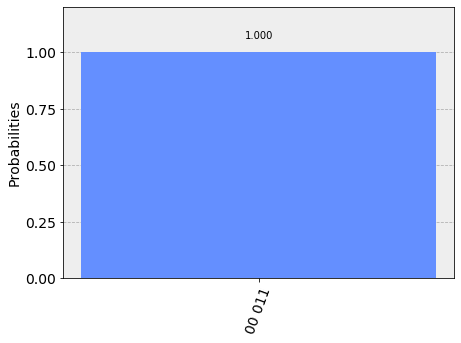

In [65]:
backend = BasicAer.get_backend('qasm_simulator')
shots = 8192
results = execute(groverCircuit, backend=backend, shots=shots).result()
answer = results.get_counts()
plot_histogram(answer)

In [66]:
print(answer)

{'00 011': 8192}


In [67]:
index = np.argmax(answer)
index = 2
print(index)

2


In [68]:
ans = np.zeros(2)
flag = False
for [i, j] in L:
    #print([i,j])
    #print(index % 4)
    if j == index % 4:
        flag = True
        ans[0] = i
        ans[1] = index
        break

if flag: 
    print("ans = ", ans)
else :
    print("failed")

ans =  [2. 2.]
